In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [56]:
data = pd.read_csv("ETH-USD.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-11-07,218.899002,221.651993,216.796005,217.182999,217.182999,1927830000
1,2018-11-08,217.326996,218.337997,212.199005,212.231003,212.231003,1769080000
2,2018-11-09,211.987000,213.315994,209.514999,210.074005,210.074005,1554750000
3,2018-11-10,209.975006,213.856995,209.804993,212.533005,212.533005,1377760000
4,2018-11-11,212.479004,212.998993,208.867996,211.339996,211.339996,1501600000
...,...,...,...,...,...,...,...
1822,2023-11-03,1800.916504,1835.072510,1779.635498,1832.795166,1832.795166,7622864055
1823,2023-11-04,1833.368896,1867.261353,1825.736572,1857.698608,1857.698608,4845080427
1824,2023-11-05,1857.395630,1911.608643,1848.620117,1894.157715,1894.157715,8867152645
1825,2023-11-06,1894.027100,1914.582642,1871.973022,1899.837402,1899.837402,8104122602


5.706652330020443


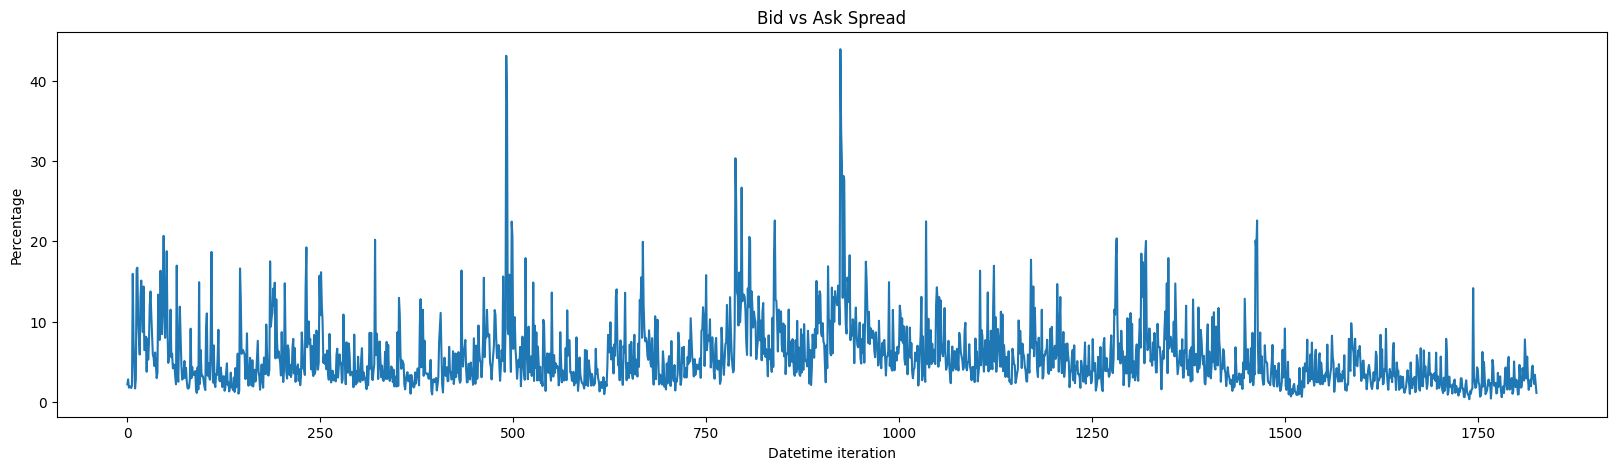

In [57]:
# See the spread
spread_percentage = ((data["High"] - data["Low"]) / data["Open"]) *1e2
data["spread"] = spread_percentage
average_spread_percentage = np.average(spread_percentage)
print(average_spread_percentage)
plt.figure(figsize=(20,5))
plt.plot(spread_percentage)
plt.title("Bid vs Ask Spread")
plt.xlabel("Datetime iteration")
plt.ylabel("Percentage")
plt.show()

In [58]:
# bollinger bands 
iterations = 18

sma = data["Close"].rolling(iterations).mean()
std = data["Close"].rolling(iterations).std()
bollinger_upper = sma + std*2
bollinger_lower = sma - std*2

data["simple_mpving_average"] = sma
data["bollinger_upper_band"] = bollinger_upper
data["bollinger_lower_band"] = bollinger_lower


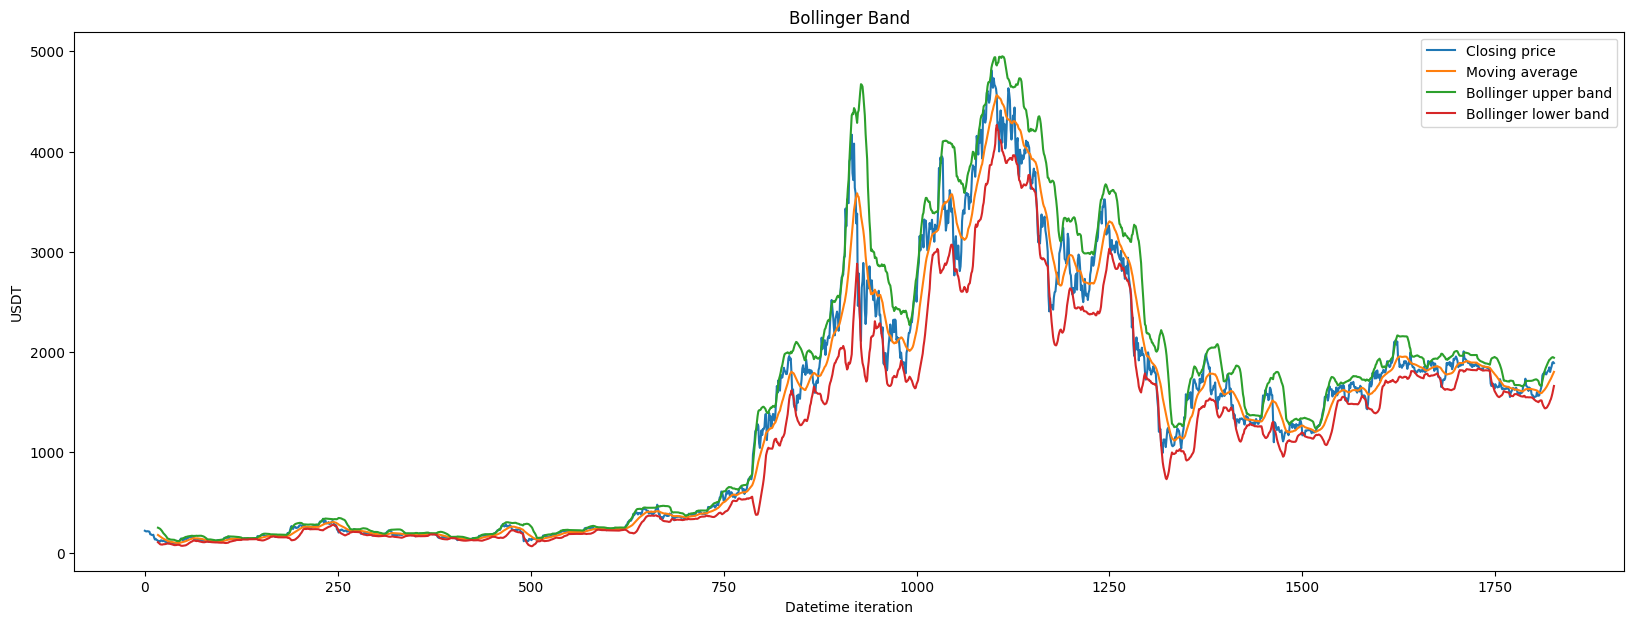

In [59]:
plt.figure(figsize=(20,7))
plt.plot(data["Close"], label="Closing price")
plt.plot(data["simple_mpving_average"], label="Moving average")
plt.plot(data["bollinger_upper_band"], label="Bollinger upper band")
plt.plot(data["bollinger_lower_band"], label="Bollinger lower band")
plt.xlabel("Datetime iteration")
plt.ylabel("USDT")
plt.title("Bollinger Band")
plt.legend()
plt.show()

In [60]:
data["bollinger_sell_signal"] = np.where(data["Close"] > data["bollinger_upper_band"], 1, 0)
data["bollinger_buy_signal"] = np.where(data["Close"] < data["bollinger_lower_band"], 1, 0)
data["bollinger_total_signal"] = data["bollinger_sell_signal"] + -1*data["bollinger_buy_signal"]

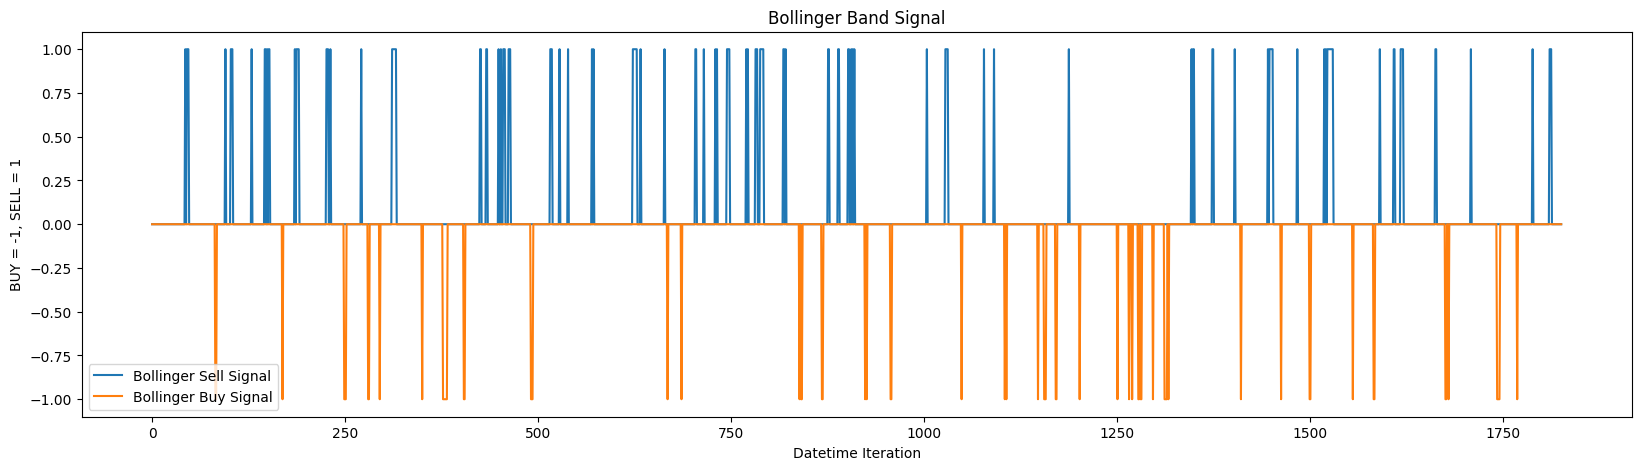

In [61]:
plt.figure(figsize=(20,5))
plt.plot(data["bollinger_sell_signal"], label="Bollinger Sell Signal")
plt.plot(-1*data["bollinger_buy_signal"], label="Bollinger Buy Signal")
# plt.plot(data["bollinger_signal"])
plt.title("Bollinger Band Signal")
plt.xlabel("Datetime Iteration")
plt.ylabel("BUY = -1, SELL = 1")
plt.legend()
plt.show()

In [62]:
# stochastic oscillator
# Define periods
k_period = 5 * 24
d_period = 3 * 24
# Adds a "n_High" column with max value of previous 14 periods
data['n_high'] = data['High'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
data['n_low'] = data['Low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
data['%K'] = (data['Close'] - data['n_low']) * 100 / (data['n_high'] - data['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
data['%D'] = data['%K'].rolling(d_period).mean()

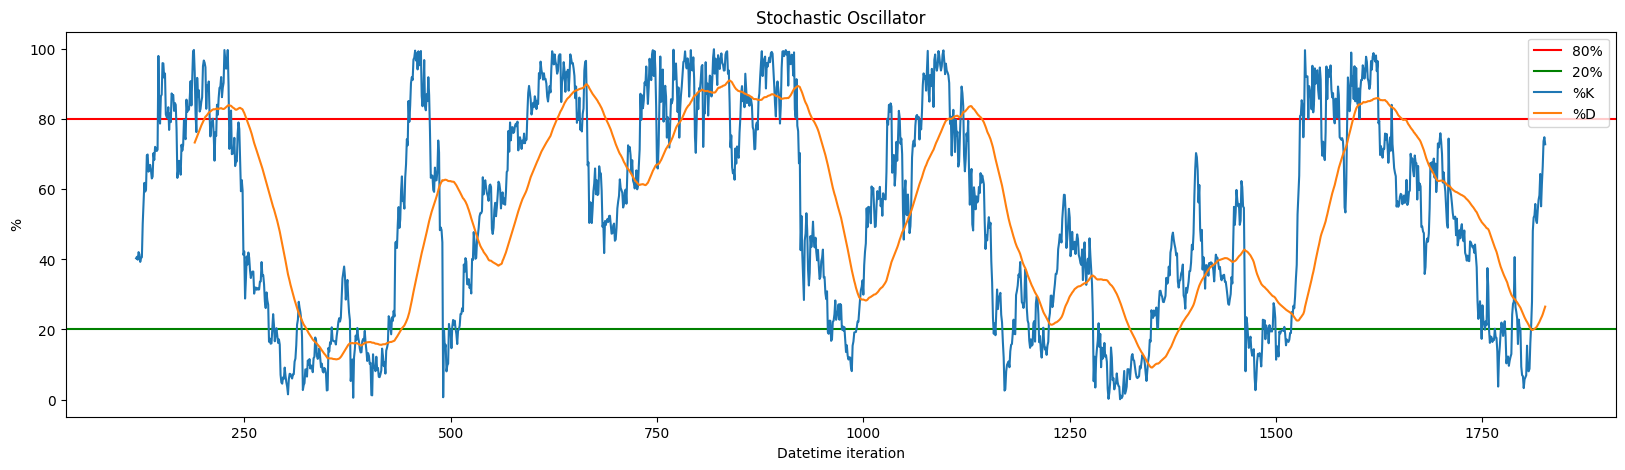

In [63]:
plt.figure(figsize=(20,5))
plt.axhline(y=80, color="r", label="80%")
plt.axhline(y=20, color="g", label="20%")
plt.plot(data['%K'], label="%K")
plt.plot(data['%D'], label="%D")
plt.title("Stochastic Oscillator")
plt.xlabel("Datetime iteration")
plt.ylabel("%")
plt.legend()
plt.show()

In [64]:
data["K80"] = np.where(data["%K"] > 80, 1, 0)
data["D80"] = np.where(data["%D"] > 80, 1, 0)
data["K20"] = np.where(data["%K"] < 20, 1, 0)
data["D20"] = np.where(data["%D"] < 20, 1, 0)

data["K80D80"] = data["K80"] * data["D80"]
data["K20D20"] = data["K20"] * data["D20"]

data["%K>%D"] = np.where(data["%K"] > data["%D"], 1, 0)
data["%K<%D"] = np.where(data["%K"] < data["%D"], 1, 0)

# overbrought state
data["stochastic_oscillator_sell_signal"] = np.where(data["K80D80"] > 0, data["%K>%D"], 0)
# oversold state
data["stochastic_oscillator_buy_signal"] = np.where(data["K20D20"] > 0, data["%K<%D"], 0)

data["stochastic_oscillator_total_signal"] = data["stochastic_oscillator_sell_signal"] + -1 * data["stochastic_oscillator_buy_signal"]

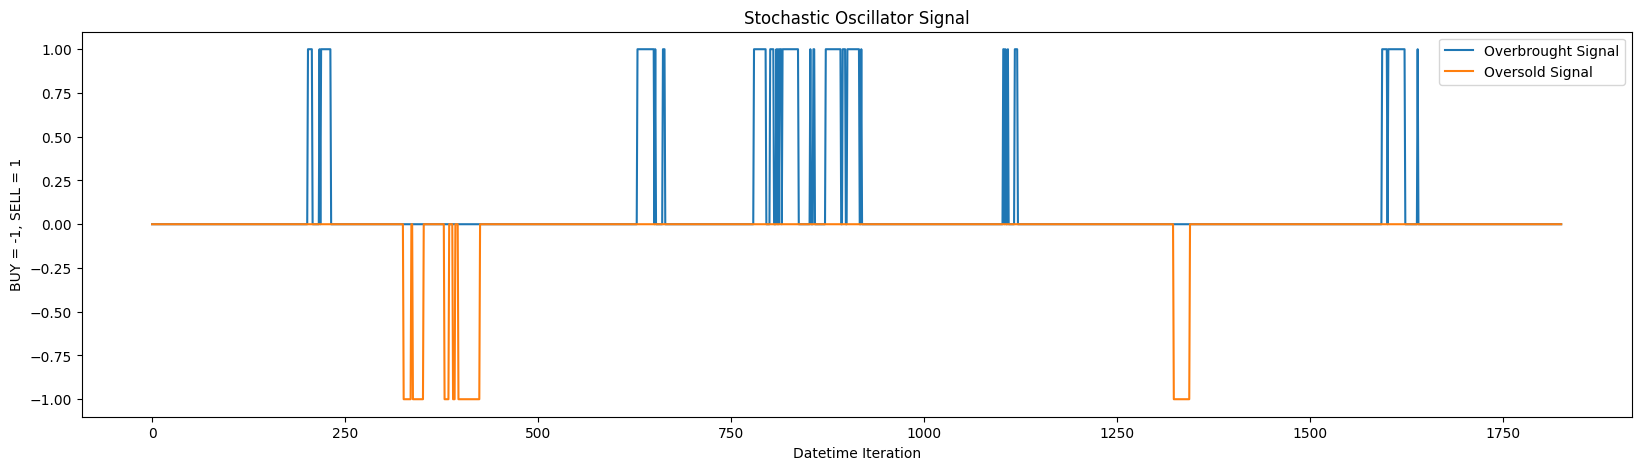

In [65]:
plt.figure(figsize=(20,5))
plt.plot(data["stochastic_oscillator_sell_signal"], label="Overbrought Signal")
plt.plot(-1*data["stochastic_oscillator_buy_signal"], label="Oversold Signal")
# plt.plot(data["stochastic_oscillator_total_signal"])
plt.title("Stochastic Oscillator Signal")
plt.xlabel("Datetime Iteration")
plt.ylabel("BUY = -1, SELL = 1")
plt.legend()
plt.show()

In [66]:
def runSimulation(data, strategy):
    # order attributes of (price, position)
    open_orders = []

    # portfolio
    starting_portfolio = 100
    trade_size = 0.25
    cutoff_trading = 10
    cumulative_return = []
    numTrades = 0
    for i in range(len(data)):

        current_data = data.iloc[i]      

        # Sell order 
        if current_data[strategy] == 1:
            if len(open_orders) > 0:
                buy_price, buy_position = open_orders[0]
                del open_orders[0]
                sell_price = current_data['Close']
                pnl = sell_price * buy_position
                starting_portfolio = starting_portfolio + pnl
                numTrades += 1
        # Buy order
        if current_data[strategy] == -1:
            if starting_portfolio > cutoff_trading:
                pending_orders = [open_orders[i][0]*open_orders[i][1] for i in range(len(open_orders))]
                buy_price = current_data['Close']
                buy_position = starting_portfolio * trade_size / buy_price
                starting_portfolio = starting_portfolio - buy_position * buy_price
                open_orders.append((buy_price, buy_position))
                numTrades += 1

        pending_orders = [current_data["Close"]*open_orders[i][1] for i in range(len(open_orders))]
        cumulative_return.append(starting_portfolio + sum(pending_orders))

    print("Total number of trades:", numTrades)
    plt.figure(figsize=(20,5))
    plt.plot(cumulative_return, label="Wealth over time")
    plt.legend()
    plt.xlabel("Datetime Iteration")
    plt.ylabel("USD")
    plt.title("Cumulative return over time with {}".format(strategy))
    plt.show()

Total number of trades: 40


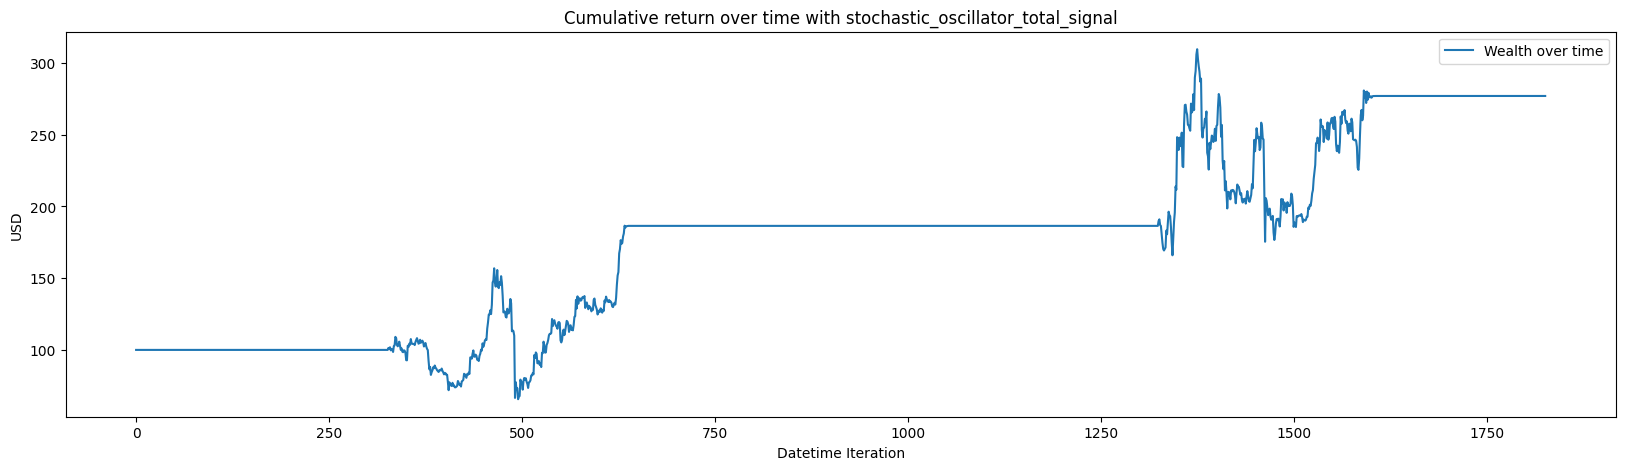

In [67]:
runSimulation(data, "stochastic_oscillator_total_signal")

Total number of trades: 125


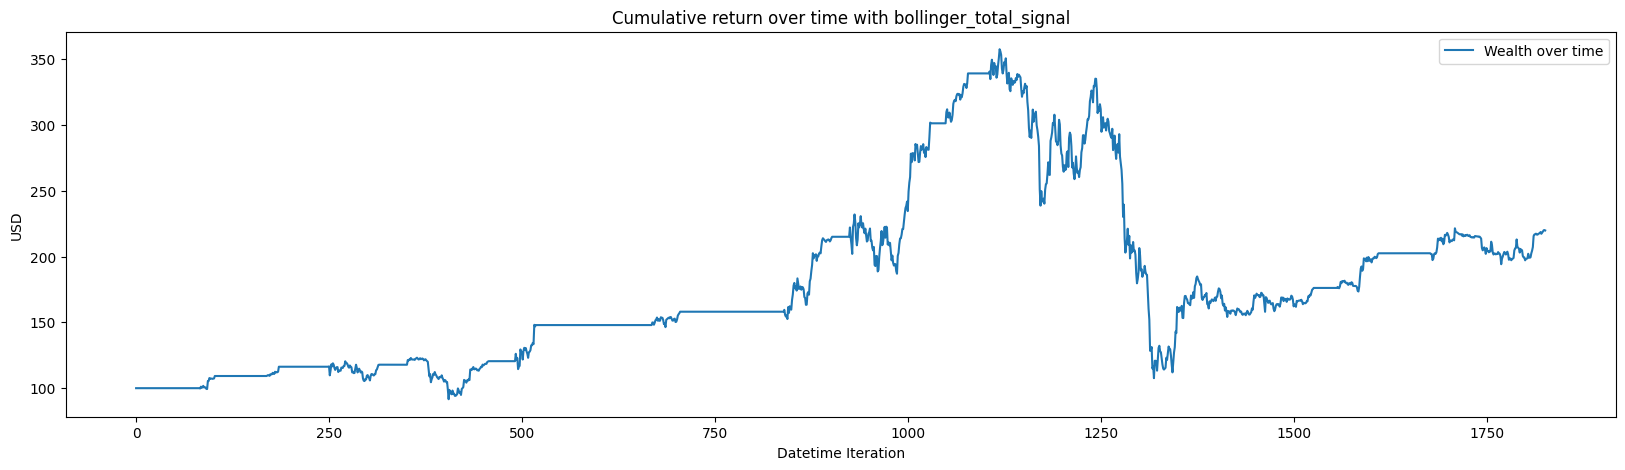

In [68]:
runSimulation(data, "bollinger_total_signal")